<a href="https://colab.research.google.com/github/JairEsc/Mat_Apl_2/blob/main/Epid_MCMC_covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from scipy.integrate import odeint

Cargamos los datos de incidencia durante 28 semanas.

924122


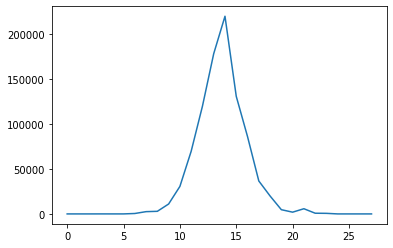

In [120]:
datos=pd.read_csv("SEIR.csv",sep=';')
plt.plot(datos['incidencia'])
Ydat=datos['incidencia']
print(np.sum(Ydat))#>90% de la población se infectó

Definimos la función del modelo SEIR que utilizaremos para ajustar los datos observados.

In [182]:
N=1e3
S0=N-1
E0=1
I0=0
R0=0
X0=[S0,E0,0,I0,R0]
INPUT=[S0,E0,I0,0,R0]
def SEIR(X,t, ps):
    try:
        be = ps['be'].value
        la = ps['la'].value
        ga = ps['ga'].value
        N = ps['N'].value
    except:
        be,la,ga,N = ps  
    S,E,I,Y,R = X
    dS = -be*S*I/N
    dE = (be*S*I/N) - la*E
    dI = la*E - ga*I
    dY = be*S*I/N
    dR = ga*I
    Xsol = np.array([dS,dE,dI,dY,dR],dtype='float64')
    Xsol = Xsol.reshape(5,)
    return(Xsol)
def SEIR_izy(X,t, N, be,la,ga):#Para no tener problemas con los parametros de las funciones.
    S,E,I,Y,R = X
    dS = -be*S*I/N
    dE = (be*S*I/N) - la*E
    dI = la*E - ga*I
    dY = be*S*I/N
    dR = ga*I
    Xsol = np.array([dS,dE,dI,dY,dR],dtype='float64')
    Xsol = Xsol.reshape(5,)
    return(Xsol)

En este ejercicio, nos gustaría hacer inferencia bayesiana sobre la distribución de los datos de incidencia. En tal caso, supongamos el siguiente esquema de trabajo.


*   D=$\{y_1,y_2,\ldots,y_{28}\}$ son los datos de incidencia.
*  Debemos proponer $\pi_{1,2,3}$ distribuciones aprior de los parámetros de nuestro modelo SEIR ($\beta,\lambda,\gamma)$ respectivamente. Pues con estas y asumiendo un modelo Poisson para la incidencia, podemos calcular la función de verosimilitud de nuestros datos.
*   $Y|D$ la distribución posterior es la distribución objetivo. Es decir, de la que nos gustaría generar observaciones. Llamemosla $f$.
*   Debemos proponer una distribución condicional $q(\cdot|y_i)$ que sea sencilla de simular.
*   Debemos proporcionar un valor inicial de la cadena $x_0$ que satisfaga que $f(x_0)>0$, de manera que MH pueda generar realizaciones de la distribución de interés.

Función de verosimilitud de las observaciones. En este caso $f$ es la función de distribución posterior usando el modelo $Poisson$.

In [183]:
#### verosimilitud
def logverosimilitud(theta):
    be,la,ga = theta
    dias = 28
    t = np.linspace(0,28,29)  ## vector de tiempos
    Xt =  odeint(func=SEIR_izy, y0=X0, t=t, args=(N,be,la,ga))
    ### Incidencia
    Inc = np.diff(Xt[:,3])#Valores de incidencia diaria.
    vers = scipy.stats.poisson.logpmf(Ydat, Inc)#Suponiendo que dado theta, los datos siguen distribucion 
            #Poisson de parámetro dado por el valor obtenido en la solución de la ODE
    ver = np.sum(vers)
    return(ver)
#### Posterior
def logposterior(theta):
  return(logaprioris(theta)+logverosimilitud(theta))


Usamos optimización numérica para conseguir una condición inicial de los parámetros y guiarnos para proponer las aprioris.

In [5]:
#!pip install lmfit

In [186]:
from lmfit import minimize, Parameters, Parameter, report_fit
from scipy.integrate import odeint
import scipy.integrate as spi
t_start = 0.0; 
t_end = 28; 
t_inc = 1.0
t_range = np.arange(t_start, t_end+t_inc, t_inc)
def g(t,ps):
    SOL = spi.odeint(SEIR,INPUT,t_range,args=(ps,))
    return np.diff(SOL[:,3])
def residual(ps,ts,data):
    #INP =  ps['Y0'].value#Solo los infectados.
    model = g(ts,ps)
    return (model-data).ravel()
params = Parameters()
params.add('be', value=2.0, min=0, max=10)
params.add('la', value=2, min=0, max=10)
params.add('ga', value=1, min=0, max=10)
params.add('N', value=float(N), min=N, max=N+1)
params.add('S0', value= float(N), min=0, max=N+1)
params.add('E0', value=float(1), min=0, max=1)
params.add('I0', value=float(0), min=0, max=1)
params.add('Y0', value=float(0), min=0, max=1)
t = np.linspace(0, 28, 29)
result = minimize(residual, params, args=(t, Ydat), method='leastsq')

final = Ydat + result.residual.reshape(Ydat.shape)
result


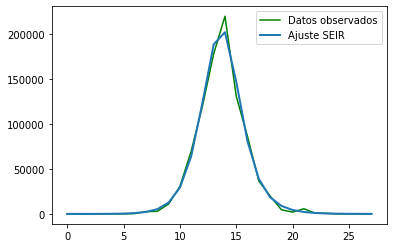

In [138]:
plt.plot(Ydat, '-g',label='Datos observados')
plt.plot(final, '-', linewidth=2,label='Ajuste SEIR');
plt.legend()
plt.show()

In [199]:
be_0=result.params['be'].value
la_0=result.params['la'].value
ga_0=result.params['ga'].value

In [171]:
def f(theta):
    return(np.exp(logaprioris(theta)+logverosimilitud(theta)))

In [198]:
print(f([be_0,la_0,ga_0]))#Fail

0.0


In [173]:
q=2
par1=[be_0/(q/10),0,q/10]  #hiperpar'ametros para beta
par2=[la_0/(q/10),0,q/10]  #hiperpar'ametros para lamba
par3=[ga_0/(q/10),0,q/10]  #hiperpar'ametros para gamma

def logaprioris(theta):
    be,la,ga = theta
    dbe = scipy.stats.gamma.logpdf(be,par1[0],par1[1],par1[2])
    dla = scipy.stats.gamma.logpdf(la,par2[0],par2[1],par2[2])
    dga = scipy.stats.gamma.logpdf(ga,par3[0],par3[1],par3[2])
    return(dbe+dla+dga)

Visualización de las distribuciones a prior.

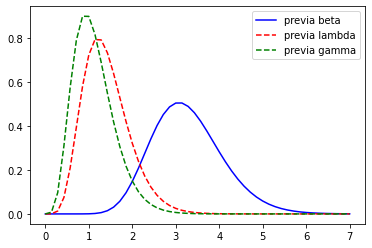

In [202]:
x = np.linspace(0., 7, 50)
prev1 = scipy.stats.gamma.pdf(x, par1[0],par1[1],par1[2])
prev2 = scipy.stats.gamma.pdf(x, par2[0],par2[1],par2[2])
prev3 = scipy.stats.gamma.pdf(x, par3[0],par3[1],par3[2])
plt.plot(x, prev1, 'b-', label='previa beta')
plt.plot(x, prev2, 'r--', label='previa lambda')
plt.plot(x, prev3, 'g--', label='previa gamma')
plt.legend(loc="best")

In [221]:
def Busca(iter_max):#Trata de buscar un valor de theta para el cual la posterior sea positiva
    positivo=False
    count=0
    theta_ini='nope'
    while positivo==False and count<iter_max:
        a = scipy.stats.gamma.rvs(par1[0],par1[1],par1[2])
        b = scipy.stats.gamma.rvs(par2[0],par2[1],par2[2])    
        c = scipy.stats.gamma.rvs(par3[0],par3[1],par3[2])
        tt = np.array([a, b, c])
        w=f(tt)#Funcion objetivo
        count+=1
        if w>0:
            theta_ini = tt
            positivo=True
            return(theta_ini)
    return theta_ini
Busca(10**4)

'nope'

In [187]:
#Segundo intento. Optimizacion numérica sobre la funcion de verosimilitud

In [219]:
from scipy.optimize import minimize
def menosloglikelihood(theta):
    return -logverosimilitud(theta)
bnds = ((0.01, 10), (0.01, 6.0),(0.01, 6.0))
x_0=minimize(fun=menosloglikelihood,x0=[be_0,la_0,ga_0],bounds=bnds)
print(x_0.x)

[7.29941598 0.04062382 0.01000014]


In [220]:
f(x_0.x)#Fail

0.0